# Brain MRI segmentation project

# Table of Contents
1. [Introduction and imports](#Introduction)
2. [Quick Overview of the Dataset](#Quick-Overview-of-the-Dataset)
3. [Data loading](#Data-loading)
4. [Model Building - Unet](#Model-Building---Unet)
5. [Model training](#Model-training)
6. [Evaluation](#Evaluation)

## Introduction and imports

### Dataset Introduction

For this project, we utilized the LGG Segmentation Dataset, which is pivotal for understanding the association between genomic subtypes of lower-grade gliomas and shape features. This dataset, as described in the studies by Buda et al. (2019) and Mazurowski et al. (2017), consists of brain MRI images accompanied by manual segmentation masks of FLAIR abnormalities. The images were sourced from The Cancer Imaging Archive (TCIA) and encompass data from 110 patients in The Cancer Genome Atlas (TCGA) lower-grade glioma collection, all of whom have FLAIR sequences and genomic cluster information available. Our goal is to perform accurate segmentation of the brain tumors in these images, leveraging the provided masks to train and evaluate our U-Net model.

In [26]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import glob  # Filename pattern matching
import random
import cv2  # Computer vision
from PIL import Image  # Image processing

import torch
import torchvision  # Computer vision tools
import torch.nn as nn  # Neural network layers
import torch.nn.functional as F  # Neural network functions
import torch.utils.data as data  # Data handling utilities
import torchvision.transforms as tt  # Image transformations
import albumentations as A  # Image augmentations
from tqdm import tqdm  # Progress bar
from mpl_toolkits.axes_grid1 import ImageGrid  # Image grid layout
from torch.utils.data import DataLoader  # Data loading
from torchvision.utils import make_grid  # Create image grids
from sklearn.model_selection import train_test_split

In [27]:
def set_seed(seed=0):
    # Ensure PyTorch operations are deterministic
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    # Set the seed for PyTorch (CPU)
    torch.manual_seed(seed)

    # Set the seed for all CUDA (GPU) devices
    torch.cuda.manual_seed_all(seed)

    # Set the seed for NumPy
    np.random.seed(seed)

    # Set the seed for Python's random module
    random.seed(seed)

    # Optionally enforce deterministic algorithms in newer PyTorch versions
    if torch.__version__ >= '1.8.0':
        torch.use_deterministic_algorithms(True)

# Set the seed for reproducibility
set_seed()


## Quick Overview of the Dataset

In [28]:
ROOT_PATH = '../input/lgg-mri-segmentation/kaggle_3m/'

mask_files = glob.glob(ROOT_PATH + '*/*_mask*')
image_files = [file.replace('_mask', '') for file in mask_files]

def diagnosis(mask_path):
    return 1 if np.max(cv2.imread(mask_path)) > 0 else 0

files_df = pd.DataFrame({"image_path": image_files,
                  "mask_path": mask_files,
                  "diagnosis": [diagnosis(x) for x in mask_files]})

files_df

,image_path,mask_path,diagnosis
0,../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...,../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...,0
1,../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...,../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...,0
2,../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...,../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...,1
3,../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...,../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...,1
4,../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...,../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...,1
...,...,...,...
3924,../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...,../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...,0
3925,../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...,../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...,0
3926,../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...,../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...,0
3927,../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...,../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...,0


In [29]:
print("Total of No Tumor:", files_df['diagnosis'].value_counts()[0])
print("Total of Tumor:", files_df['diagnosis'].value_counts()[1])

Total of No Tumor: 2556
Total of Tumor: 1373


In [30]:
# Splitting the dataset into training data (train_df), validation data (val_df),
#and test data (test_df) with specified proportions.
train_df, val_df = train_test_split(files_df, stratify=files_df['diagnosis'], test_size=0.1, random_state=0)
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

train_df, test_df = train_test_split(train_df, stratify=train_df['diagnosis'], test_size=0.15, random_state=0)
train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

print("Train: {}\nVal: {}\nTest: {}".format(train_df.shape, val_df.shape, test_df.shape))

Train: (3005, 3)
Val: (393, 3)
Test: (531, 3)


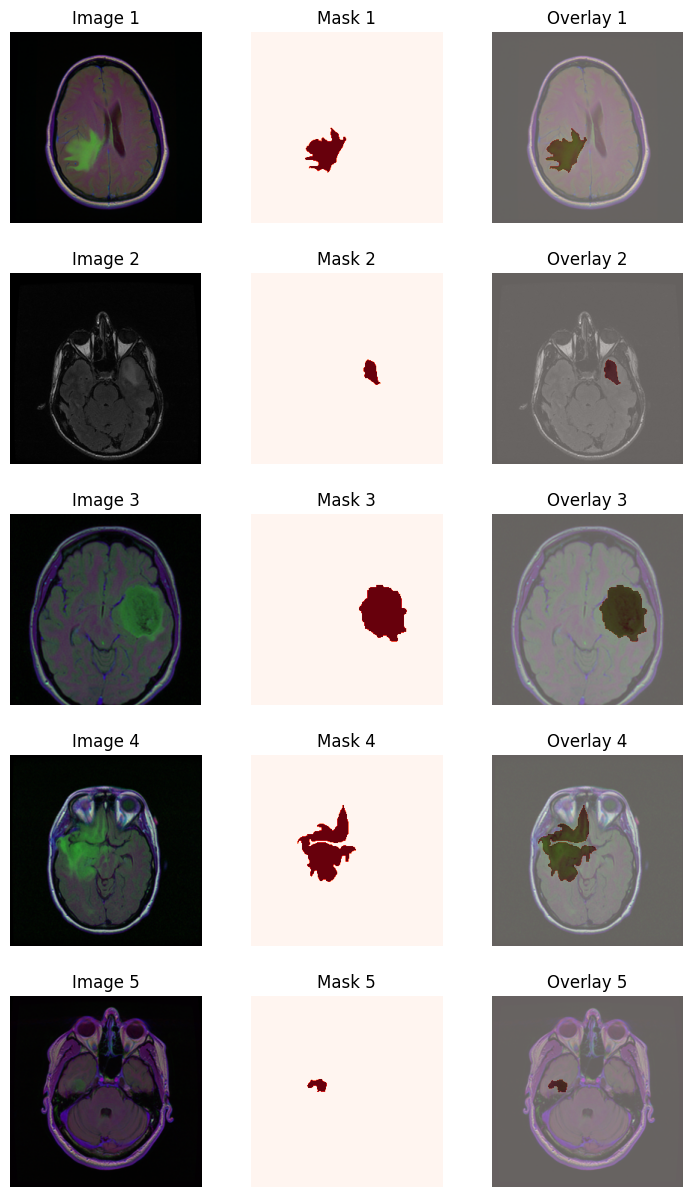

In [31]:
images, masks = [], []

df_positive = train_df[train_df['diagnosis'] == 1].sample(5).values

for sample in df_positive:
    img = cv2.imread(sample[0])
    mask = cv2.imread(sample[1], cv2.IMREAD_GRAYSCALE)
    images.append(img)
    masks.append(mask)

fig = plt.figure(figsize=(15, 15))
grid = ImageGrid(fig, 111, nrows_ncols=(5, 3), axes_pad=0.5)


for i, (img, mask) in enumerate(zip(images, masks)):
    # Image without mask
    grid[3 * i].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    grid[3 * i].set_title(f"Image {i + 1}", fontsize=12)
    grid[3 * i].axis('off')

    # Mask only (with colormap)
    grid[3 * i + 1].imshow(mask, cmap='Reds')
    grid[3 * i + 1].set_title(f"Mask {i + 1}", fontsize=12)
    grid[3 * i + 1].axis('off')

    # Overlay of image and mask
    grid[3 * i + 2].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    grid[3 * i + 2].imshow(mask, cmap='Reds', alpha=0.4)
    grid[3 * i + 2].set_title(f"Overlay {i + 1}", fontsize=12)
    grid[3 * i + 2].axis('off')

plt.show()

## Data loading

In [32]:
class BrainDataset(data.Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        image = cv2.imread(self.df.iloc[idx, 0])
        image = np.array(image)/255.
        mask = cv2.imread(self.df.iloc[idx, 1], 0)
        mask = np.array(mask)/255.

        if self.transform is not None:
            aug = self.transform(image=image, mask=mask)
            image = aug['image']
            mask = aug['mask']

        image = image.transpose((2,0,1))
        image = torch.from_numpy(image).type(torch.float32)
        image = tt.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))(image)
        mask = np.expand_dims(mask, axis=-1).transpose((2,0,1))
        mask = torch.from_numpy(mask).type(torch.float32)

        return image, mask

In [33]:
# Define transformations for training, validation, and testing datasets
train_transform = A.Compose([
    A.Resize(width=128, height=128, p=1.0),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.01, scale_limit=0.04, rotate_limit=0, p=0.25),
])

val_transform = A.Compose([
    A.Resize(width=128, height=128, p=1.0),
    A.HorizontalFlip(p=0.5),
])

test_transform = A.Compose([
    A.Resize(width=128, height=128, p=1.0),
])

In [34]:
set_seed()

train_ds = BrainDataset(train_df, train_transform)
val_ds = BrainDataset(val_df, val_transform)
test_ds = BrainDataset(test_df, test_transform)

In [35]:
def dataset_info(dataset):
    print(f'Size of dataset: {len(dataset)}')
    index = random.randint(0, len(dataset) - 1)
    img, label = dataset[index]
    if isinstance(img, torch.Tensor):
        img = img.permute(1, 2, 0).cpu().numpy()
    if isinstance(label, torch.Tensor):
        label = label.squeeze().cpu().numpy()
    print(f'Sample-{index} Image size: {img.shape}, Mask size: {label.shape}')
    print(f'Image data type: {img.dtype}, Mask data type: {label.dtype}')
    print(f'Image value range: [{img.min()}, {img.max()}]')
    print(f'Mask value range: [{label.min()}, {label.max()}]')

In [36]:
print('Train dataset:')
dataset_info(train_ds)
print("--------------------------------------------------------------------")
print('Validation dataset:')
dataset_info(val_ds)
print("--------------------------------------------------------------------")
print('Test dataset:')
dataset_info(test_ds)

Train dataset:
Size of dataset: 3005
Sample-1577 Image size: (128, 128, 3), Mask size: (128, 128)
Image data type: float32, Mask data type: float32
Image value range: [-2.1179039478302, 2.0081918239593506]
Mask value range: [0.0, 0.0]
--------------------------------------------------------------------
Validation dataset:
Size of dataset: 393
Sample-183 Image size: (128, 128, 3), Mask size: (128, 128)
Image data type: float32, Mask data type: float32
Image value range: [-2.1179039478302, 2.212984800338745]
Mask value range: [0.0, 0.0]
--------------------------------------------------------------------
Test dataset:
Size of dataset: 531
Sample-288 Image size: (128, 128, 3), Mask size: (128, 128)
Image data type: float32, Mask data type: float32
Image value range: [-2.1179039478302, 1.0408716201782227]
Mask value range: [0.0, 0.0]


In [37]:
batch_size = 64

set_seed()
train_dl = DataLoader(train_ds,
                      batch_size,
                      shuffle=True,
                      num_workers=2,
                      pin_memory=True)
set_seed()
val_dl = DataLoader(val_ds,
                    batch_size,
                    num_workers=2,
                    pin_memory=True)
test_dl = DataLoader(val_ds,
                    batch_size,
                    num_workers=2,
                    pin_memory=True)

In [38]:
images, masks = next(iter(train_dl))
print(images.shape)
print(masks.shape)

torch.Size([64, 3, 128, 128])
torch.Size([64, 1, 128, 128])


# Model Building - Unet

### Why U-Net is Suited for Brain MRI Segmentation ?

U-Net is an ideal model for brain MRI segmentation due to its specialized architecture designed for biomedical image analysis. Its encoder-decoder structure captures contextual information while preserving spatial details through skip connections, allowing for high-resolution segmentation maps. U-Net excels at handling the variability in medical images, such as diverse brain structures and lesions, and is effective even with limited training samples. This robustness against overfitting makes U-Net a preferred choice in clinical settings, where accurate and precise segmentation is crucial for informed decision-making.

Here I used an handmade version of the Unet, you can find more details about it in my other project dedicated to it.


In [39]:
class DoubleConv(nn.Module):
  def __init__(self, in_channels, out_channels):
    super(DoubleConv,self).__init__()
    self.conv = nn.Sequential(
        nn.Conv2d(in_channels,out_channels,3,1,1,bias=False), # Set bias to false because we use BatchNorm
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels,out_channels,3,1,1,bias=False),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
    )

  def forward(self,x):
    return self.conv(x)

In [40]:
class UNET(nn.Module):
  def __init__(self, in_channels=3, out_channels=1, features=[64, 128, 256, 512]):
    super(UNET,self).__init__()
    self.downs = nn.ModuleList()
    self.ups = nn.ModuleList()
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    # Down part of the UNET
    for feature in features:
      self.downs.append(DoubleConv(in_channels,feature))
      in_channels = feature

    self.bottleneck = DoubleConv(features[-1],features[-1]*2)

    # Up part of the UNET
    for feature in reversed(features):
      self.ups.append(
          nn.ConvTranspose2d(
              feature*2,feature, kernel_size=2, stride= 2
          )
      )
      self.ups.append(DoubleConv(feature*2, feature))

    self.final_conv = nn.Conv2d(features[0],out_channels,kernel_size=1)

  def forward(self, x):
    skip_connections = []

    for down in self.downs:
      x = down(x)
      skip_connections.append(x)
      x = self.pool(x)

    x = self.bottleneck(x)
    skip_connections = skip_connections[::-1]

    for idx in range(0,len(self.ups),2):
      x = self.ups[idx](x)
      skip_connection = skip_connections[idx//2]

      # Resize in case input image is not divisible by 16
      # Should not impact accuracy (only one pixel is modified)
      if x.shape != skip_connection.shape:
        x = TF.resize(x,size=skip_connection.shape[2:])

      concat_skip = torch.cat((skip_connection, x), dim=1)
      x = self.ups[idx+1](concat_skip)

    # Apply Sigmoid to constrain outputs between 0 and 1
    return torch.sigmoid(self.final_conv(x))

In [41]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNET(3, 1).to(device)

# Verifying Model Architecture and Output Shape
out = model(torch.randn(1, 3, 128, 128).to(device))
assert out.shape == torch.Size([1,1,128,128])

## Model training

### DICE Score and Why We Chose It

The DICE score, also known as the Dice Similarity Coefficient (DSC), is a statistical measure used to evaluate the accuracy of image segmentation models. It quantifies the overlap between the predicted segmentation and the ground truth by comparing their areas. The DICE score ranges from 0 to 1, where 1 represents perfect overlap (i.e., the prediction exactly matches the ground truth), and 0 indicates no overlap at all.

Mathematically, the DICE score is defined as:

$$\text{DICE} = \frac{2 |A \cap B|}{|A| + |B|}$$

Where:
- $A$  is the predicted segmentation,
- $B$ is the ground truth segmentation,
- $|A \cap B|$ represents the area of overlap between the prediction and the ground truth.

We chose the DICE score as the evaluation metric for our MRI brain segmentation project because it directly measures the similarity between predicted and actual segmented regions. This is particularly important in medical imaging tasks, where precise boundary alignment is critical to ensure accurate diagnosis or treatment planning. The DICE score emphasizes both precision and recall, making it ideal for assessing how well our model segments complex brain structures in MRI scans.


In [42]:
# Dice coefficient metric
def dice_coef_metric(pred, label):
    pred_sum = pred.sum()
    label_sum = label.sum()
    intersection = 2.0 * (pred * label).sum()
    union = pred_sum + label_sum
    if pred_sum == 0 and label_sum == 0:
        return 1.0
    return intersection / union

# Dice coefficient loss
def dice_coef_loss(pred, label, smooth=1.0):
    intersection = 2.0 * (pred * label).sum() + smooth
    union = pred.sum() + label.sum() + smooth
    return 1 - (intersection / union)

# Combined BCE + Dice loss
def bce_dice_loss(pred, label, smooth=1.0):
    dice_loss = dice_coef_loss(pred, label, smooth)
    bce_loss = nn.BCELoss()(pred, label)
    return dice_loss + bce_loss

In [43]:
# Function to perform the training loop for the model.
def train_loop(model, loader, loss_func):
    model.train()
    train_losses = []
    train_dices = []

    for i, (image, mask) in enumerate(loader):
        image = image.to(device)
        mask = mask.to(device)
        outputs = model(image)

# Convert outputs to numpy array for post-processing
        out_cut = np.copy(outputs.data.cpu().numpy())
        out_cut[np.nonzero(out_cut < 0.5)] = 0.0
        out_cut[np.nonzero(out_cut >= 0.5)] = 1.0

        dice = dice_coef_metric(out_cut, mask.data.cpu().numpy())
        loss = loss_func(outputs, mask)
        train_losses.append(loss.item())
        train_dices.append(dice)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    return train_dices, train_losses

In [44]:
# Function to perform evaluation loop for the model.
def eval_loop(model, loader, loss_func, training=True):
    model.eval()
    val_loss = 0
    val_dice = 0
    with torch.no_grad():
        for step, (image, mask) in enumerate(loader):
            image = image.to(device)
            mask = mask.to(device)

            outputs = model(image)
            loss = loss_func(outputs, mask)

    # Convert outputs to numpy array for post-processing
            out_cut = np.copy(outputs.data.cpu().numpy())
            out_cut[np.nonzero(out_cut < 0.5)] = 0.0
            out_cut[np.nonzero(out_cut >= 0.5)] = 1.0
            dice = dice_coef_metric(out_cut, mask.data.cpu().numpy())

            val_loss += loss
            val_dice += dice

        val_mean_dice = val_dice / step
        val_mean_loss = val_loss / step

        if training:
            scheduler.step(val_mean_dice)

    return val_mean_dice, val_mean_loss

In [45]:
# Function to train the model and evaluate on validation data across epochs.
def train_model(train_loader, val_loader, loss_func, optimizer, scheduler, num_epochs):
    train_loss_history = []
    train_dice_history = []
    val_loss_history = []
    val_dice_history = []

    for epoch in range(num_epochs):
        train_dices, train_losses = train_loop(model, train_loader, loss_func)
        train_mean_dice = np.array(train_dices).mean()
        train_mean_loss = np.array(train_losses).mean()
        val_mean_dice, val_mean_loss = eval_loop(model, val_loader, loss_func)

        train_loss_history.append(np.array(train_losses).mean())
        train_dice_history.append(np.array(train_dices).mean())
        val_loss_history.append(val_mean_loss)
        val_dice_history.append(val_mean_dice)

        print('Epoch: {}/{} |  Train Loss: {:.3f}, Val Loss: {:.3f}, Train DICE: {:.3f}, Val DICE: {:.3f}'.format(epoch+1, num_epochs, train_mean_loss, val_mean_loss, train_mean_dice,val_mean_dice))

    return train_loss_history, train_dice_history, val_loss_history, val_dice_history

In [46]:
# Define the optimizer with Adam optimizer and initial learning rate of 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Define the learning rate scheduler with ReduceLROnPlateau, monitoring 'max' validation metric, and patience of 3 epochs
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=3)

# Number of epochs for training
num_epochs = 25

In [47]:
%%time
train_loss_history, train_dice_history, val_loss_history, val_dice_history = train_model(train_dl, val_dl, bce_dice_loss, optimizer, scheduler, num_epochs)

Epoch: 1/25 |  Train Loss: 1.312, Val Loss: 1.400, Train DICE: 0.407, Val DICE: 0.532
Epoch: 2/25 |  Train Loss: 1.044, Val Loss: 1.137, Train DICE: 0.556, Val DICE: 0.787
Epoch: 3/25 |  Train Loss: 0.864, Val Loss: 1.052, Train DICE: 0.599, Val DICE: 0.447
Epoch: 4/25 |  Train Loss: 0.672, Val Loss: 1.825, Train DICE: 0.607, Val DICE: 0.261
Epoch: 5/25 |  Train Loss: 0.522, Val Loss: 0.659, Train DICE: 0.625, Val DICE: 0.672
Epoch: 6/25 |  Train Loss: 0.407, Val Loss: 0.659, Train DICE: 0.680, Val DICE: 0.635
Epoch: 7/25 |  Train Loss: 0.387, Val Loss: 0.353, Train DICE: 0.684, Val DICE: 0.892
Epoch: 8/25 |  Train Loss: 0.338, Val Loss: 0.327, Train DICE: 0.728, Val DICE: 0.912
Epoch: 9/25 |  Train Loss: 0.322, Val Loss: 0.313, Train DICE: 0.742, Val DICE: 0.925
Epoch: 10/25 |  Train Loss: 0.320, Val Loss: 0.309, Train DICE: 0.741, Val DICE: 0.926
Epoch: 11/25 |  Train Loss: 0.313, Val Loss: 0.304, Train DICE: 0.746, Val DICE: 0.928
Epoch: 12/25 |  Train Loss: 0.303, Val Loss: 0.294, 

## Evaluation

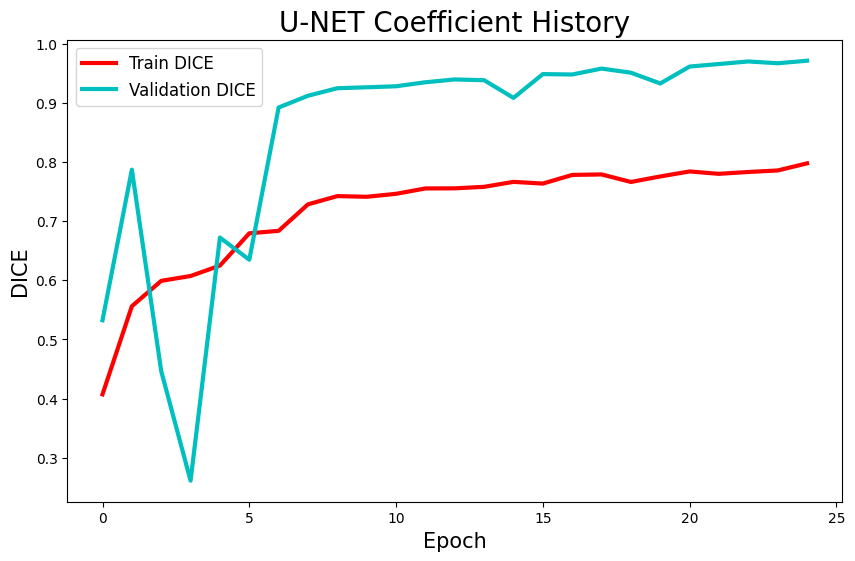

In [48]:
def plot_dice_history(model_name, train_dice_history, val_dice_history, num_epochs):

    x = np.arange(num_epochs)
    fig = plt.figure(figsize=(10, 6))
    plt.plot(x, train_dice_history, label='Train DICE', lw=3, c="r")
    plt.plot(x, val_dice_history, label='Validation DICE', lw=3, c="c")

    plt.title(f"{model_name}", fontsize=20)
    plt.legend(fontsize=12)
    plt.xlabel("Epoch", fontsize=15)
    plt.ylabel("DICE", fontsize=15)

    plt.show()

# Example usage to plot Dice coefficient history for a UNet model
plot_dice_history('U-NET Coefficient History', train_dice_history, val_dice_history, num_epochs)

In [49]:
%%time
test_dice, test_loss = eval_loop(model, test_dl, bce_dice_loss, training=False)
print("Mean IoU/DICE: {:.3f}%, Loss: {:.3f}".format((100*test_dice), test_loss))

Mean IoU/DICE: 97.460%, Loss: 0.233
CPU times: user 2.5 s, sys: 189 ms, total: 2.68 s
Wall time: 1.74 s


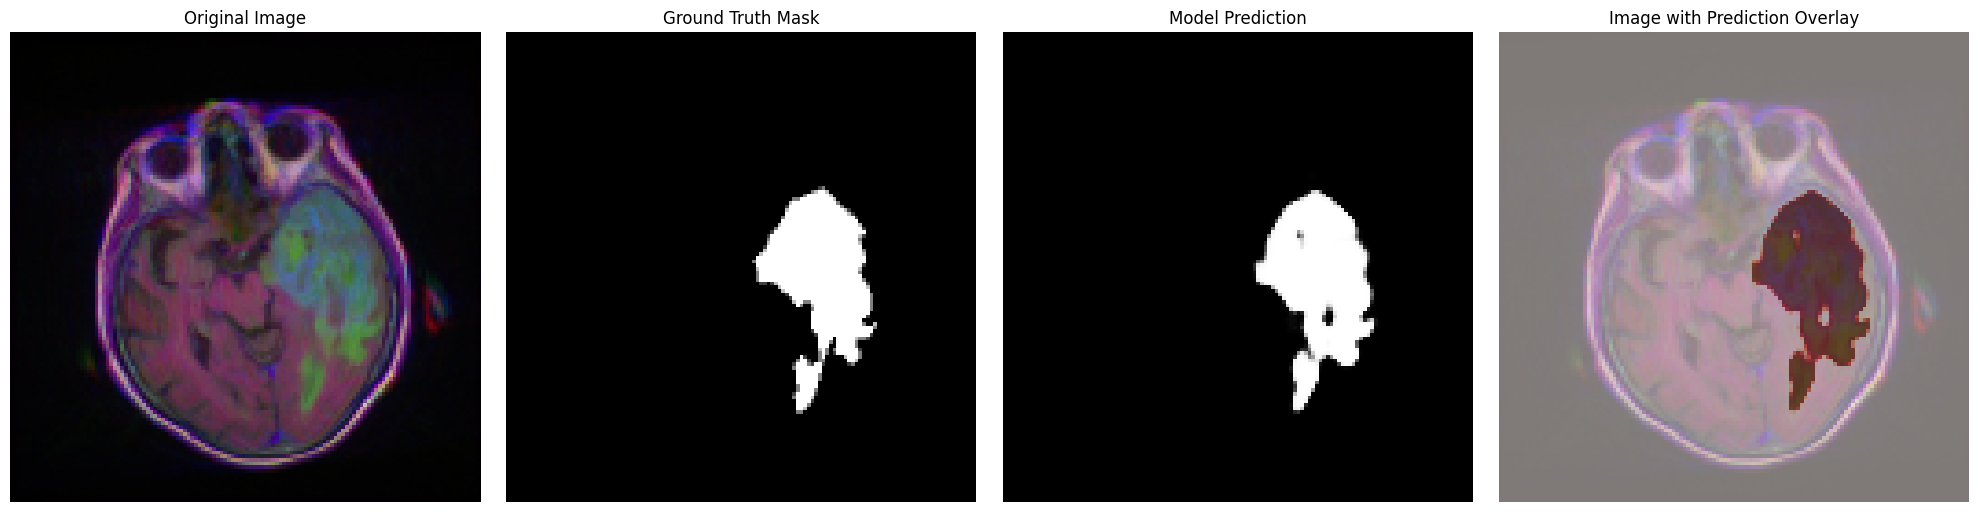

In [50]:
test_sample = test_df[test_df["diagnosis"] == 1].sample(24).values[0]
image = cv2.resize(cv2.imread(test_sample[0]), (128, 128))
mask = cv2.resize(cv2.imread(test_sample[1], cv2.IMREAD_GRAYSCALE), (128, 128))  # Load mask as grayscale

image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

pred = torch.tensor(image.astype(np.float32) / 255.).unsqueeze(0).permute(0, 3, 1, 2)
pred = tt.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))(pred)
pred = model(pred.to(device))
pred = pred.detach().cpu().numpy()[0, 0, :, :]

pred = (pred - pred.min()) / (pred.max() - pred.min())

fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
ax[0].imshow(image_rgb)
ax[0].set_title("Original Image")
ax[0].axis('off')
ax[1].imshow(mask, cmap='gray')
ax[1].set_title("Ground Truth Mask")
ax[1].axis('off')
ax[2].imshow(pred, cmap='gray')
ax[2].set_title("Model Prediction")
ax[2].axis('off')
ax[3].imshow(image_rgb)
ax[3].imshow(pred, cmap='Reds', alpha=0.5)
ax[3].set_title("Image with Prediction Overlay")
ax[3].axis('off')
plt.tight_layout()
plt.show()

In this project, we developed a custom U-Net model for MRI brain segmentation and achieved an impressive DICE score of 97% on the testing set. This high performance demonstrates the effectiveness of our model in accurately identifying and segmenting brain structures from MRI scans. The U-Net architecture, tailored to our specific data, proved to be well-suited for this task, offering precise segmentation results. While the results are promising, further optimization and validation on diverse datasets could enhance the model's generalization and robustness in clinical applications.

In [51]:
torch.save(model.state_dict(), 'brain-mri-unet.pth')